# Import modules

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from math import exp

# Initial parameters

In [2]:
# Population size
n = 1  # useless here

# Default Time beginning
t = 0

# Default trial duration
duration = 2.00  # second

# Default Time resolution
dt = 0.0001  # second 0.0001

# Initialization of the random generator (reproductibility !)
np.random.seed(1)

In [3]:
connections = ["CtxTha", "StnCtx", "StrCtx", "GpiStr", "GpiStn", "ThaGpi"]
structures = ["Ctx", "Stn", "Str", "Gpi", "Tha"]

# Thresholds (if from original paper x200: Leblois et al., 2006)
h = {
    "Ctx": 20.0,
    "Stn": -17,
    "Str": 2.0,
    "Gpi": 20.0,
    "Tha": -47.0
}

# inputs
I = dict()
for stc in structures:
    I[stc] = 0

Gpi_Ie = 0
Gpi_Ii = 0

G = {
    "CtxTha": 0.97,
    "StnCtx": 2.0,
    "StrCtx": 0.45,
    "GpiStr": 12.0,
    "GpiStn": 3.4,
    "ThaGpi": 0.3
}

# tau:
tau = {
    "CtxTha": 0.005,
    "StnCtx": 0.020,
    "StrCtx": 0.005,
    "GpiStr": 0.005,
    "GpiStn": 0.005,
    "ThaGpi": 0.005
}

# Delays:
D = {
    "CtxTha": 0.005,
    "StnCtx": 0.005,
    "StrCtx": 0.006,
    "GpiStr": 0.010,
    "GpiStn": 0.005,
    "ThaGpi": 0.005
}


# Activities at time t:
m = dict()

# Activities at dt
dm = dict()

# Connectivity J
J = dict()

for con in connections:

    m[con] = 0
    dm[con] = 0
    J[con] = 1

input_mapping = {
    "Ctx": "CtxTha",
    "Str": "StrCtx",
    "Stn": "StnCtx",
    "Tha": "ThaGpi"
}

activities_mapping = {
    "CtxTha": "Tha",
    "StrCtx": "Ctx",
    "StnCtx": "Ctx",
    "ThaGpi": "Gpi",
    "GpiStr": "Str",
    "GpiStn": "Stn"
}

# Noise level (%)  = sigma from paper
N = {
    "Ctx": 0.030,
    "Str": 0.005,
    "Stn": 0.020,
    "Gpi": 0.050,
    "Tha": 0.050
}

# Noise Function

In [4]:
# White Gaussian Noise
def WGnoise(size=1):
    n = np.random.normal(0, 1, size=size)
    return n

def noise(Z, level):  # Z = size of the population
    Z = (np.random.uniform(-level / 2, level / 2, Z)) * Z
    return Z

# Corrected Input function

In [5]:
# Function returning the corrected Input
def Ic(Input=0, threshold=0):
    if Input - threshold <= 0:
        return 0
    else:
        return (Input - threshold)

# Activity at time t-Delta (delay) function

In [6]:
# function to get the index "-delay/dt" in the list representing m(t-Delta)
def mdelta(synapse_value, delay, t, dt):
    if t < delay:  # if the delay is the time is too small, we take m(t-delta)=0
        return 0
    else:  # if the time is above or equal to the delay, we can find the m(t-delta)
        return synapse_value[int(-delay / dt)]

# ================= Simulation Core =================

In [7]:
n_period = int(duration // dt) + 1
time_value = np.arange(0, duration, dt)

mDelta, value = dict(), dict()

for con in connections:
    value[con] = np.zeros(n_period)

for t in range(1, n_period):

    for con in connections:
        
        value[con][t] = m[con]  # command to add all activities of each population in a list respectively ; 
        # after each iteration

        mDelta[con] = mdelta(value[con][:t + 1], D[con], time_value[t], dt)

        m[con] += dm[con]  # we add the activity (dm) to the global activity (m),
            # after a step dt ; for all population
            # stored in the list ("PopulationNames"_value)

    # noise_level = WGnoise(len(structures) + 2)
    for stc in structures:
        if stc == "Gpi":
            #Gpi_Ie = G["GpiStn"] * J["GpiStn"] * mDelta["GpiStn"] + WGnoise()
            #Gpi_Ii = - G["GpiStr"] * J["GpiStr"] * mDelta["GpiStr"] + WGnoise()
            I["Gpi"] = G["GpiStn"] * J["GpiStn"] * mDelta["GpiStn"] - G["GpiStr"] * J["GpiStr"] * mDelta["GpiStr"] \
                + WGnoise()
        elif stc == "Tha":
            con = input_mapping[stc]
            I[stc] = - G[con] * J[con] * mDelta[con] + WGnoise()
        else:
            con = input_mapping[stc]
            I[stc] = G[con] * J[con] * mDelta[con] + WGnoise()

    for con in connections:
        # Update of activities
        stc = activities_mapping[con]
        dm[con] = dt * (-m[con] + Ic(I[stc], h[stc])) / tau[con] + float(noise(1, N[stc]))

# Plotting results

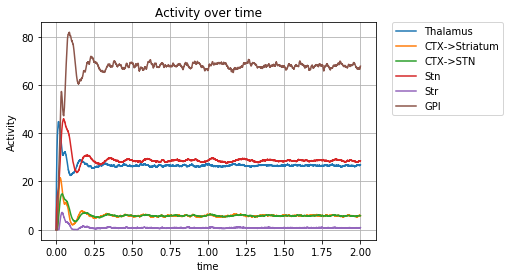

In [8]:
plt.plot(time_value, value["CtxTha"], label='Thalamus')
plt.plot(time_value, value["StrCtx"], label='CTX->Striatum')
plt.plot(time_value, value["StnCtx"], label='CTX->STN')
plt.plot(time_value, value["GpiStn"], label='Stn')
plt.plot(time_value, value["GpiStr"], label='Str')
plt.plot(time_value, value["ThaGpi"], label='GPI')

plt.title('Activity over time')
plt.ylabel('Activity')
plt.xlabel('time')
plt.grid()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()